<a href="https://colab.research.google.com/github/YilinGu1010/final/blob/main/AI4EO_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Mapping of Earthquake-Triggered Landslides from Sentinel-2 Imagery
Landslides are a destructive natural hazard, often triggered by earthquakes or heavy rainfall, posing serious threats to infrastructure and human lives. Rapid detection of landslide-affected areas is therefore crucial for post-disaster assessment and hazard modeling.

This project focuses on the magnitude 7.8 earthquake that struck the Turkey–Syria border region on February 6, 2023, which triggered a large number of landslides. Based on remote sensing imagery and field investigations, experts identified approximately 2,596 earthquake-induced landslides, primarily concentrated in the northern part of the affected area. (Kocaman, Sultan, et al., 2025)

In this project, high-resolution multispectral remote sensing data provided by Sentinel-2 will be utilized to generate vegetation loss maps using indices such as the Normalized Difference Vegetation Index (NDVI). Although NDVI is commonly used for landslide detection, traditional methods often rely on threshold-based strategies that require prior knowledge of vegetation conditions. To overcome this limitation, the project employs unsupervised learning methods—specifically, K-means clustering and Gaussian Mixture Models (GMM)—to assess whether landslide traces can be reliably detected without predefined thresholds or local environmental knowledge.

# Preparation

Install the necessary packages

In [4]:
! pip install rasterio
! pip install codecarbon

[codecarbon INFO @ 16:39:10] Energy consumed for RAM : 0.000208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:39:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:39:10] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 16:39:10] 0.001094 kWh of electricity used since the beginning.


Start the emission tracker.

In [5]:
from codecarbon import EmissionsTracker

tracker = EmissionsTracker(project_name="Landslide_Detection")
tracker.start()

[codecarbon WARNING @ 16:39:17] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 16:39:17] [setup] RAM Tracking...
[codecarbon INFO @ 16:39:17] [setup] CPU Tracking...
[codecarbon WARNING @ 16:39:19] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 16:39:19] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 16:39:19] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 16:39:19] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:39:19] [setup] GPU Tracking...
[codecarbon INFO @ 16:39:19] No GPU found.
[codecarbon INFO @ 16:39:19] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Import the required packages and mount to google drive.

In [6]:
import os
import requests
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
from shapely.geometry import Polygon, Point, box, mapping
from pyproj import Proj, Transformer
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import cv2
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Fetching

Fetch the data of areas affected by the TurkeySyria Earthquake.

In [7]:
def make_api_request(url, method="GET", data=None, headers=None):
    global access_token
    if not headers:
        headers = {"Authorization": f"Bearer {access_token}"}

    response = requests.request(method, url, json=data, headers=headers)
    if response.status_code in [401, 403]:
        global refresh_token
        access_token = refresh_access_token(refresh_token)
        headers["Authorization"] = f"Bearer {access_token}"
        response = requests.request(method, url, json=data, headers=headers)
    return response


def query_sentinel2_TurkeySyria_data(start_date, end_date, token):
    """
    Queries Sentinel-3 OLCI data within a specified time range from the Copernicus Data Space,
    targeting data collected over the Arctic region.

    Parameters:
    start_date (str): Start date in 'YYYY-MM-DD' format.
    end_date (str): End date in 'YYYY-MM-DD' format.
    token (str): Access token for authentication.

    Returns:
    DataFrame: Contains details about the Sentinel-3 OLCI images.
    """

    all_data = []
    TurkeySyria_polygon = (
        "POLYGON ((36.9450 36.2020, 36.9450 37.3500, 38.3000 37.3500, 38.3000 36.2020, 36.9450 36.2020))"
        )

    filter_string = (
        f"Collection/Name eq 'SENTINEL-2' and "
        f"Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'productType' and att/Value eq 'S2MSI2A') and "
        f"ContentDate/Start gt {start_date}T00:00:00.000Z and ContentDate/Start lt {end_date}T23:59:59.999Z"
    )

    next_url = (
        f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?"
        f"$filter={filter_string} and "
        f"OData.CSC.Intersects(area=geography'SRID=4326;{TurkeySyria_polygon}')&"
        f"$top=1000"
    )

    headers = {"Authorization": f"Bearer {token}"}

    while next_url:
        response = make_api_request(next_url, headers=headers)
        if response.status_code == 200:
            data = response.json()["value"]
            all_data.extend(data)
            next_url = response.json().get("@odata.nextLink")
        else:
            print(f"Error fetching data: {response.status_code} - {response.text}")
            break

    return pd.DataFrame(all_data)


def get_access_and_refresh_token(username, password):
    """Retrieve both access and refresh tokens."""
    url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    data = {
        "grant_type": "password",
        "username": username,
        "password": password,
        "client_id": "cdse-public",
    }
    response = requests.post(url, data=data)
    response.raise_for_status()
    tokens = response.json()
    return tokens["access_token"], tokens["refresh_token"]


def refresh_access_token(refresh_token):
    """Attempt to refresh the access token using the refresh token."""
    url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    data = {
        "grant_type": "refresh_token",
        "refresh_token": refresh_token,
        "client_id": "cdse-public",
    }
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    try:
        response = requests.post(url, headers=headers, data=data)
        response.raise_for_status()  # This will throw an error for non-2xx responses
        return response.json()["access_token"]
    except requests.exceptions.HTTPError as e:
        print(f"Failed to refresh token: {e.response.status_code} - {e.response.text}")
        if e.response.status_code == 400:
            print("Refresh token invalid, attempting re-authentication...")
            # Attempt to re-authenticate
            username = username
            password = password
            # This requires securely managing the credentials, which might not be feasible in all contexts
            access_token, new_refresh_token = get_access_and_refresh_token(
                username, password
            )  # This is a placeholder
            refresh_token = (
                new_refresh_token  # Update the global refresh token with the new one
            )
            return access_token
        else:
            raise

def download_single_product(
    product_id, file_name, access_token, download_dir="downloaded_products"
):
    """
    Download a single product from the Copernicus Data Space.

    :param product_id: The unique identifier for the product.
    :param file_name: The name of the file to be downloaded.
    :param access_token: The access token for authorization.
    :param download_dir: The directory where the product will be saved.
    """
    # Ensure the download directory exists
    os.makedirs(download_dir, exist_ok=True)

    # Construct the download URL
    url = (
        f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"
    )

    # Set up the session and headers
    headers = {"Authorization": f"Bearer {access_token}"}
    session = requests.Session()
    session.headers.update(headers)

    # Perform the request
    response = session.get(url, headers=headers, stream=True)

    # Check if the request was successful
    if response.status_code == 200:
        # Define the path for the output file
        output_file_path = os.path.join(download_dir, file_name + ".zip")

        # Stream the content to a file
        with open(output_file_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
        print(f"Downloaded: {output_file_path}")
    else:
        print(
            f"Failed to download product {product_id}. Status Code: {response.status_code}"
        )

Download the zip files.

In [8]:
# Authenticate with Copernicus Data Space
username = "zcfbgub@ucl.ac.uk" # Change to your username
password = "20030526Gyl!" # Change to your password
access_token, refresh_token = get_access_and_refresh_token(username, password)

# Define Time Ranges for Pre- and Post-earthquake
pre_eq_start_date = "2023-01-05"
pre_eq_end_date = "2023-01-06"
post_eq_start_date = "2023-08-05"
post_eq_end_date = "2023-08-06"

# Query Sentinel-2 Products Covering 2023 TurkeySyria Earthquake Affected Area
pre_eq_sentinel2_data = query_sentinel2_TurkeySyria_data(
    pre_eq_start_date, pre_eq_end_date, access_token
)

post_eq_sentinel2_data = query_sentinel2_TurkeySyria_data(
    post_eq_start_date, post_eq_end_date, access_token
)

# Download the Selected Sentinel-2 Product for Each Time Range
download_dir = "/content/drive/MyDrive/AI/Week 10/"

# Download Pre-Earthquake Product
product_id = pre_eq_sentinel2_data['Id'][0]
file_name = pre_eq_sentinel2_data['Name'][0]
download_single_product(product_id, file_name, access_token, download_dir)

# Download Post-Earthquake Product
product_id = post_eq_sentinel2_data['Id'][0]
file_name = post_eq_sentinel2_data['Name'][0]
download_single_product(product_id, file_name, access_token, download_dir)

[codecarbon INFO @ 16:39:40] Energy consumed for RAM : 0.000292 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:39:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:39:40] Energy consumed for All CPU : 0.001239 kWh
[codecarbon INFO @ 16:39:40] 0.001531 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:39:49] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:39:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:39:49] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 16:39:49] 0.000438 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:39:55] Energy consumed for RAM : 0.000333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:39:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:39:55] Energy consumed for All CPU : 0.001417 kWh
[codecarbon INFO @ 16:39:55] 0.001750 kWh 

Downloaded: /content/drive/MyDrive/AI/Week 10/S2B_MSIL2A_20230105T082239_N0509_R121_T37SCB_20230105T101215.SAFE.zip


[codecarbon INFO @ 16:40:55] Energy consumed for RAM : 0.000500 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:40:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:40:55] Energy consumed for All CPU : 0.002125 kWh
[codecarbon INFO @ 16:40:55] 0.002625 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:41:04] Energy consumed for RAM : 0.000292 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:41:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:41:04] Energy consumed for All CPU : 0.001240 kWh
[codecarbon INFO @ 16:41:04] 0.001531 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:41:10] Energy consumed for RAM : 0.000542 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:41:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:41:10] Energy consumed for All CPU : 0.002302 kWh
[codecarbon INFO @ 16:41:10] 0.002843 kWh 

Downloaded: /content/drive/MyDrive/AI/Week 10/S2A_MSIL2A_20230805T080611_N0510_R078_T37SCB_20241015T101626.SAFE.zip


Unzip the files.

In [11]:
!unzip -u "/content/drive/MyDrive/AI/Week 10/S2A_MSIL2A_20230805T080611_N0510_R078_T37SDB_20241015T101626.SAFE.zip" -d "/content/drive/MyDrive/AI/Week 10/"

Archive:  /content/drive/MyDrive/AI/Week 10/S2A_MSIL2A_20230805T080611_N0510_R078_T37SDB_20241015T101626.SAFE.zip


In [12]:
!unzip -u "/content/drive/MyDrive/AI/Week 10/S2B_MSIL2A_20230105T082239_N0510_R121_T37SDA_20240810T133355.SAFE.zip" -d "/content/drive/MyDrive/AI/Week 10/"

Archive:  /content/drive/MyDrive/AI/Week 10/S2B_MSIL2A_20230105T082239_N0510_R121_T37SDA_20240810T133355.SAFE.zip


# Align the Pre- and Post-Earthquake Images
Since the two Sentinel-2 datasets were acquired several months apart, pixel-level analysis for detecting landslide scars necessitates accurate spatial alignment. To ensure this, the Enhanced Correlation Coefficient (ECC) algorithm was employed for image registration.

In [13]:
def crop_sentinel2_bands(bands_paths: dict, bbox_wgs84: box, band_order: list):
    cropped_bands = []
    transform_out = None
    crs_out = None
    for band_key in band_order:
        with rasterio.open(bands_paths[band_key]) as src:
            if src.crs.to_string() != 'EPSG:4326':
                transformer = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True)
                minx, miny = transformer.transform(*bbox_wgs84.bounds[0:2])
                maxx, maxy = transformer.transform(*bbox_wgs84.bounds[2:4])
                geom = [mapping(box(minx, miny, maxx, maxy))]
            else:
                geom = [mapping(bbox_wgs84)]
            out_img, out_transform = mask(src, geom, crop=True)
            cropped_bands.append(out_img[0])
            transform_out = out_transform
            crs_out = src.crs
    return np.dstack(cropped_bands), transform_out, crs_out

def estimate_ecc_euclidean(ref_band, mov_band, num_iterations=5000, termination_eps=1e-8):
    ref_f = ref_band.astype(np.float32) / max(1, ref_band.max())
    mov_f = mov_band.astype(np.float32) / max(1, mov_band.max())
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, num_iterations, termination_eps)
    cc, warp_matrix = cv2.findTransformECC(
        templateImage=ref_f,
        inputImage=mov_f,
        warpMatrix=warp_matrix,
        motionType=cv2.MOTION_EUCLIDEAN,
        criteria=criteria
    )
    return warp_matrix, cc

def warp_stack(stack, warp_matrix, dsize):
    H, W = dsize
    warped_bands = []
    for i in range(stack.shape[2]):
        band = stack[:, :, i]
        warped = cv2.warpAffine(
            band,
            warp_matrix,
            (W, H),
            flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=0
        )
        warped_bands.append(warped)
    return np.dstack(warped_bands)

def apply_fixed_normalization(arr, vmin, vmax):
    return np.clip((arr - vmin) / (vmax - vmin), 0, 1)

In [15]:
# Define the Initial Region of Interest with Buffer
buffer = 0.02
bbox = box(36.9450 - buffer, 36.2020 - buffer, 38.3000 + buffer, 37.3500 + buffer)

# Define Band Paths
path = '/content/drive/MyDrive/AI/Week 10/'

base_pre = (
    "S2A_MSIL2A_20230805T080611_N0510_R078_T37SDB_20241015T101626.SAFE/GRANULE/L2A_T37SDB_A042403_20230805T081222/IMG_DATA/R20m/"
)
bands_paths_pre = {
    'B11': path + base_pre + 'T37SDB_20230805T080611_B11_20m.jp2',
    'B8': path + base_pre + 'T37SDB_20230805T080611_B8A_20m.jp2',
    'B4': path + base_pre + 'T37SDB_20230805T080611_B04_20m.jp2',
    'B3': path + base_pre + 'T37SDB_20230805T080611_B03_20m.jp2',
    'B2': path + base_pre + 'T37SDB_20230805T080611_B02_20m.jp2'
}

base_post = (
    "S2B_MSIL2A_20230105T082239_N0510_R121_T37SDA_20240810T133355.SAFE/GRANULE/L2A_T37SDA_A030463_20230105T082246/IMG_DATA/R20m/"
)
bands_paths_post = {
    'B11': path + base_post + 'T37SDA_20230105T082239_B11_20m.jp2',
    'B8': path + base_post + 'T37SDA_20230105T082239_B8A_20m.jp2',
    'B4': path + base_post + 'T37SDA_20230105T082239_B04_20m.jp2',
    'B3': path + base_post + 'T37SDA_20230105T082239_B03_20m.jp2',
    'B2': path + base_post + 'T37SDA_20230105T082239_B02_20m.jp2'
}

# Define Bands & Crop Buffered ROI
all_bands = ['B11','B8', 'B4', 'B3', 'B2']
all_pre_raw, _, _  = crop_sentinel2_bands(bands_paths_pre,  bbox, all_bands)
all_post_raw, _, _ = crop_sentinel2_bands(bands_paths_post, bbox, all_bands)

# Estimate Warp & Apply
warp_mat, cc_val = estimate_ecc_euclidean(all_pre_raw[..., 0], all_post_raw[..., 0])
print(f"ECC‐Euclidean converged, CC = {cc_val:.4f}")
H, W = all_pre_raw.shape[:2]
all_post_aligned = warp_stack(all_post_raw, warp_mat, (H, W))

# Crop to Fixed Pixel Window
x_min, x_max = 150, 450
y_min, y_max = 250, 600
all_pre_raw = all_pre_raw[y_min:y_max, x_min:x_max, :]
all_post_aligned = all_post_aligned[y_min:y_max, x_min:x_max, :]

# Crop the Original Unaligned Post-EQ to Same Window for Illustration
all_post_unaligned = all_post_raw[y_min:y_max, x_min:x_max, :]

# Create Valid-Data Masks
valid_pre_mask = np.all(all_pre_raw > 0, axis=2)
valid_post_mask = np.all(all_post_aligned > 0, axis=2)
valid_unaligned_mask = np.all(all_post_unaligned > 0, axis=2)

[codecarbon INFO @ 16:44:10] Energy consumed for RAM : 0.001041 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:44:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:44:10] Energy consumed for All CPU : 0.004426 kWh
[codecarbon INFO @ 16:44:10] 0.005468 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:44:19] Energy consumed for RAM : 0.000833 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:44:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:44:20] Energy consumed for All CPU : 0.003541 kWh
[codecarbon INFO @ 16:44:20] 0.004375 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:44:25] Energy consumed for RAM : 0.001083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:44:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:44:25] Energy consumed for All CPU : 0.004603 kWh
[codecarbon INFO @ 16:44:25] 0.005686 kWh 

ECC‐Euclidean converged, CC = 0.3415


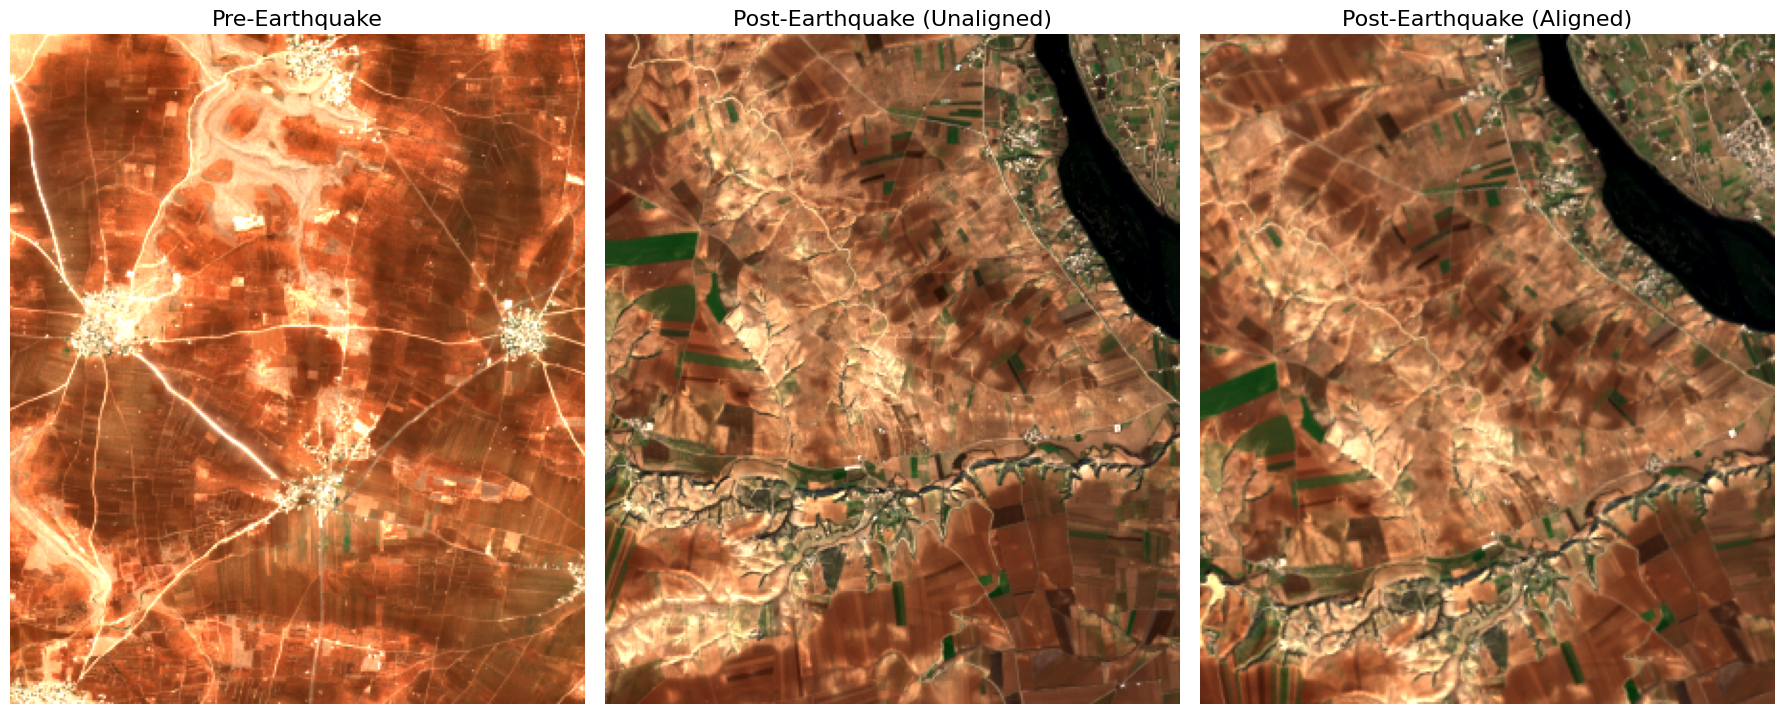

In [16]:
# Plotting the RGB Images
rgb_pre = all_pre_raw[:, :, -3:]
rgb_unaligned_post = all_post_unaligned[:, :, -3:]
rgb_aligned_post = all_post_aligned[:, :, -3:]

vmin = np.percentile(rgb_aligned_post, 2)
vmax = np.percentile(rgb_aligned_post, 99)

rgb_pre_norm = apply_fixed_normalization(rgb_pre, vmin, vmax)
rgb_unaligned = apply_fixed_normalization(rgb_unaligned_post, vmin, vmax)
rgb_aligned = apply_fixed_normalization(rgb_aligned_post, vmin, vmax)

rgb_pre_norm[~valid_pre_mask] = 0
rgb_unaligned[~valid_unaligned_mask] = 0
rgb_aligned[~valid_post_mask] = 0

fig, axes = plt.subplots(1, 3, figsize=(18, 7))
axes[0].imshow(rgb_pre_norm)
axes[0].set_title("Pre-Earthquake",fontsize=16)
axes[0].axis('off')

axes[1].imshow(rgb_unaligned)
axes[1].set_title("Post-Earthquake (Unaligned)",fontsize=16)
axes[1].axis('off')

axes[2].imshow(rgb_aligned)
axes[2].set_title("Post-Earthquake (Aligned)",fontsize=16)
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Create a NDVI Mask
To identify landslide scars, the Normalized Difference Vegetation Index (NDVI) was employed, which uses near-infrared and red spectral bands to evaluate vegetation density. By analyzing the change in NDVI values before and after the earthquake, areas of vegetation loss—indicative of landslide activity—could be approximated. Additionally, the Bare Soil Index (BSI) was computed to support subsequent clustering-based classification.

In [17]:
# Define Threshold Value
ndvi_threshold = 0.15

# Convert Bands to Float for Safe Division (Pre-Earthquake)
swir_pre = all_pre_raw[:, :, 0].astype(np.float32)
nir_pre = all_pre_raw[:, :, 1].astype(np.float32)
red_pre = all_pre_raw[:, :, 2].astype(np.float32)
green_pre = all_pre_raw[:, :, 3].astype(np.float32)
blue_pre = all_pre_raw[:, :, 4].astype(np.float32)

# NDVI Calculation (Pre-Earthquake)
den_ndvi_pre = nir_pre + red_pre
ndvi_pre = np.zeros_like(den_ndvi_pre, dtype=np.float32)
valid_ndvi_pre = den_ndvi_pre != 0
ndvi_pre[valid_ndvi_pre] = (nir_pre[valid_ndvi_pre] - red_pre[valid_ndvi_pre]) / den_ndvi_pre[valid_ndvi_pre]

# NDVI Mask (Pre-Earthquake)
mask_ndvi_pre = (ndvi_pre > ndvi_threshold).astype(np.uint8)

# BSI Calculation (Pre-Earthquake)
num_bsi_pre = (swir_pre + red_pre) - (nir_pre + blue_pre)
den_bsi_pre = (swir_pre + red_pre) + (nir_pre + blue_pre)
bsi_pre = np.zeros_like(den_bsi_pre, dtype=np.float32)
valid_bsi_pre = den_bsi_pre != 0
bsi_pre[valid_bsi_pre] = num_bsi_pre[valid_bsi_pre] / den_bsi_pre[valid_bsi_pre]

# Convert Bands to Float for Safe Division (Post-Earthquake)
swir_post = all_post_aligned[:, :, 0].astype(np.float32)
nir_post = all_post_aligned[:, :, 1].astype(np.float32)
red_post = all_post_aligned[:, :, 2].astype(np.float32)
green_post = all_post_aligned[:, :, 3].astype(np.float32)
blue_post = all_post_aligned[:, :, 4].astype(np.float32)

# NDVI Calculation (Post-Earthquake)
den_ndvi_post = nir_post + red_post
ndvi_post = np.zeros_like(den_ndvi_post, dtype=np.float32)
valid_ndvi_post = den_ndvi_post != 0
ndvi_post[valid_ndvi_post] = (nir_post[valid_ndvi_post] - red_post[valid_ndvi_post]) / den_ndvi_post[valid_ndvi_post]

# NDVI Mask (Post-Earthquake)
mask_ndvi_post = (ndvi_post > ndvi_threshold).astype(np.uint8)

# BSI Calculation (Post-Earthquake)
num_bsi_post = (swir_post + red_post) - (nir_post + blue_post)
den_bsi_post = (swir_post + red_post) + (nir_post + blue_post)
bsi_post = np.zeros_like(den_bsi_post, dtype=np.float32)
valid_bsi_post = den_bsi_post != 0
bsi_post[valid_bsi_post] = num_bsi_post[valid_bsi_post] / den_bsi_post[valid_bsi_post]

# NDVI Landslide Mask
ndvi_diff = ndvi_post - ndvi_pre
landslide_mask = ((ndvi_diff < -0.2) & (ndvi_pre > ndvi_threshold)).astype(np.uint8)

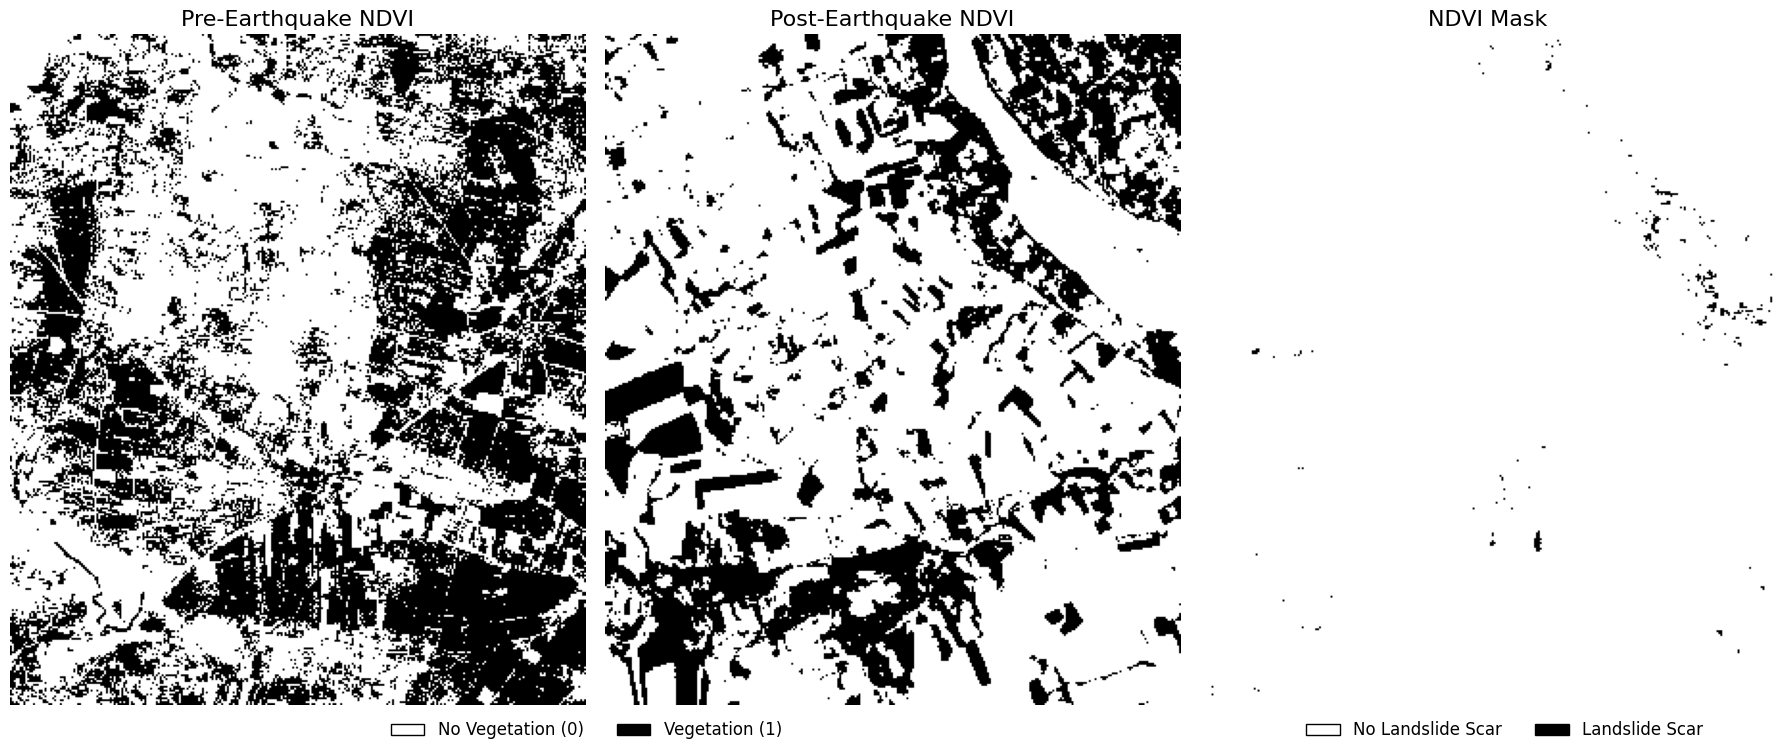

In [18]:
# Create Legend for Binary NDVI Mask
ndvi_patches = [
    Rectangle((0, 0), 1, 1, facecolor=plt.cm.binary(0), edgecolor='black'),
    Rectangle((0, 0), 1, 1, facecolor=plt.cm.binary(0.99), edgecolor='black'),
]
ndvi_labels = ['No Vegetation (0)', 'Vegetation (1)']

scar_patches = [
    Rectangle((0, 0), 1, 1, facecolor=plt.cm.binary(0), edgecolor='black'),
    Rectangle((0, 0), 1, 1, facecolor='black', edgecolor='black')
]
scar_labels = ['No Landslide Scar', 'Landslide Scar']

# Plot the Result
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

axes[0].imshow(mask_ndvi_pre, cmap="binary")
axes[0].set_title("Pre-Earthquake NDVI", fontsize = 16)
axes[0].axis('off')

axes[1].imshow(mask_ndvi_post, cmap="binary")
axes[1].set_title("Post-Earthquake NDVI", fontsize = 16)
axes[1].axis('off')

axes[2].imshow(landslide_mask, cmap="binary")
axes[2].set_title("NDVI Mask", fontsize = 16)
axes[2].axis('off')

# Add Legend Below First Two Plots
fig.legend(
    handles=ndvi_patches,
    labels=ndvi_labels,
    loc='lower center',
    ncol=2,
    bbox_to_anchor=(0.33, -0.05),
    prop={'size': 12},
    frameon=False
)

# Add Landslide Scar Legend under the Third Plot
fig.legend(
    handles=scar_patches,
    labels=scar_labels,
    loc='lower center',
    bbox_to_anchor=(0.84, -0.05),  # Positioned under third plot
    ncol=2,
    prop={'size': 12},
    frameon=False
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.02)
plt.show()

# K-Means Clustering - 2 Clusters
Rather than using the raw Sentinel-2 bands—which showed poor performance in separating vegetation from bare soil—NDVI and BSI indices were utilized for clustering. These indices provided a clearer distinction between land cover types and enabled the analysis to proceed without manually defining a threshold for NDVI. By incorporating both NDVI and BSI, the clustering approach captured a more comprehensive representation of surface changes.

The first approach involved applying K-Means clustering with two classes to differentiate vegetated areas from bare soil. By comparing the clustering outcomes before and after the earthquake, the extent of the landslide scar was identified.

In [19]:
# Stack NIR and Red Bands for Pre-Earthquake
band_stack_pre = np.dstack([ndvi_pre, bsi_pre])
valid_pre_mask = np.all(band_stack_pre > -1, axis=2)
Pre_EQ_X = band_stack_pre[valid_pre_mask].reshape((-1, 2))

# Apply K-means on Pre-Earthquake Image
kmeans_pre = KMeans(n_clusters=2, random_state=24095819).fit(Pre_EQ_X)
labels_pre = kmeans_pre.labels_

# Create Label Image for Pre-Earthquake
labels_image_pre = np.full(band_stack_pre.shape[:2], -1, dtype=int)
labels_image_pre[valid_pre_mask] = labels_pre

# Stack NIR and Red Bands for Post-Earthquake
band_stack_post = np.dstack([ndvi_post, bsi_post])
valid_post_mask = np.all(band_stack_post > -1, axis=2)
Post_EQ_X = band_stack_post[valid_post_mask].reshape((-1, 2))

# Apply K-means on Post-Earthquake Image
kmeans_post = KMeans(n_clusters=2, random_state=24095819).fit(Post_EQ_X)
labels_post = kmeans_post.labels_

# Create Label Image for Post-Earthquake
labels_image_post = np.full(band_stack_post.shape[:2], -1, dtype=int)
labels_image_post[valid_post_mask] = labels_post

# Landslide mask: vegetation lost
landslide_mask_kmeans_2_cluster = ((labels_image_pre == 1) & (labels_image_post == 0)).astype(np.uint8)

[codecarbon INFO @ 16:49:40] Energy consumed for RAM : 0.001958 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:49:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:49:40] Energy consumed for All CPU : 0.008322 kWh
[codecarbon INFO @ 16:49:40] 0.010280 kWh of electricity used since the beginning.


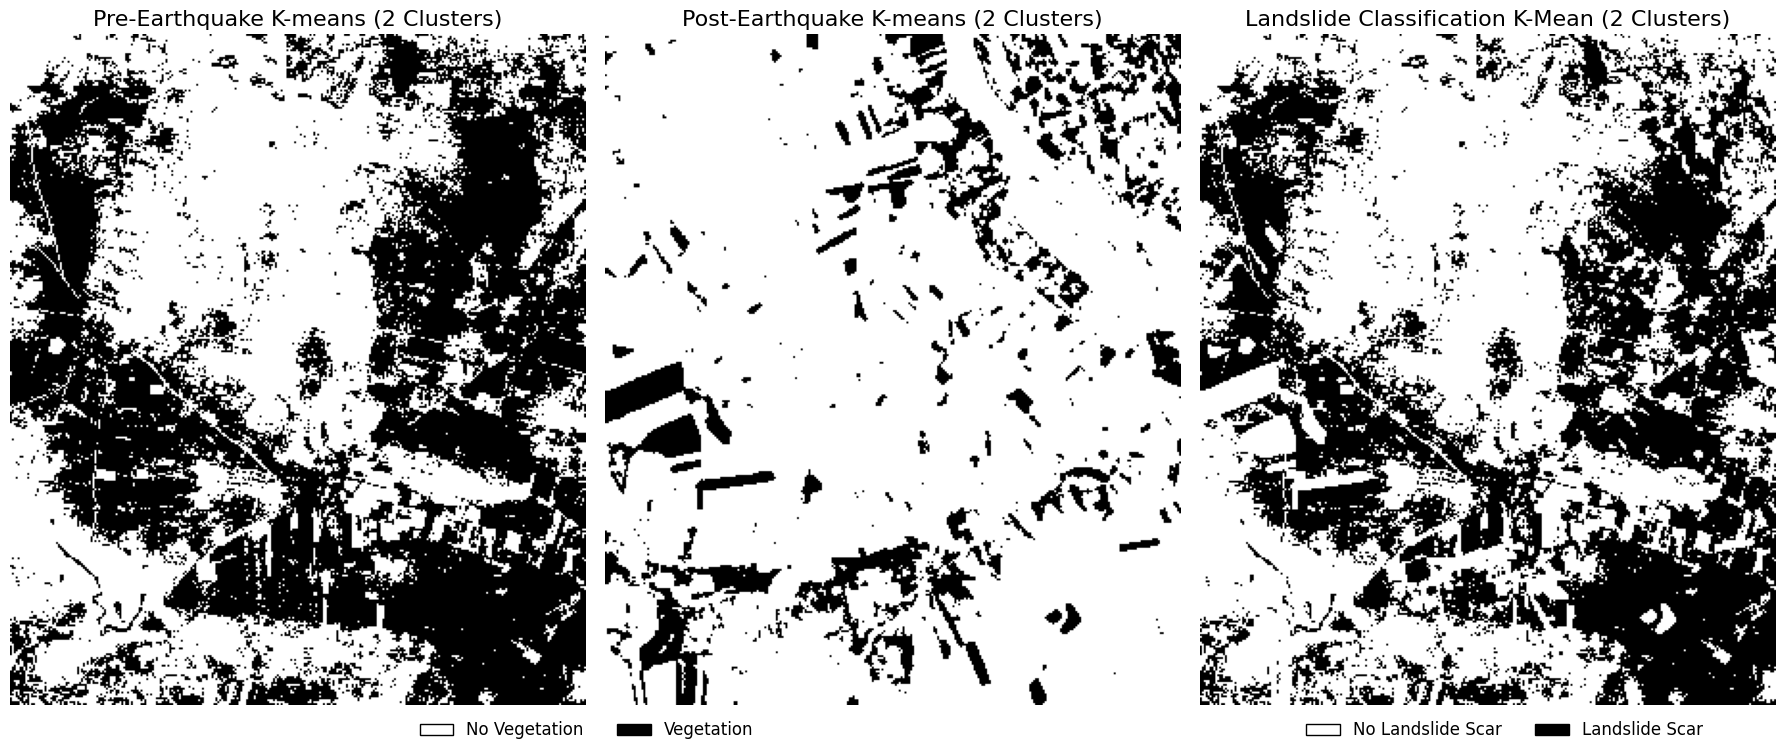

In [20]:
# Create Legend for Binary Cluster Labels
patches = [
    Rectangle((0, 0), 1, 1, facecolor=plt.cm.binary(0), edgecolor='black'),
    Rectangle((0, 0), 1, 1, facecolor=plt.cm.binary(0.99), edgecolor='black'),
]
labels = ['No Vegetation', 'Vegetation']

scar_patches = [
    Rectangle((0, 0), 1, 1, facecolor=plt.cm.binary(0), edgecolor='black'),
    Rectangle((0, 0), 1, 1, facecolor='black', edgecolor='black')
]
scar_labels = ['No Landslide Scar', 'Landslide Scar']

# Plotting Side-by-Side Result with Shared Legend
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

axes[0].imshow(labels_image_pre, cmap='binary')
axes[0].set_title('Pre-Earthquake K-means (2 Clusters)', fontsize = 16)
axes[0].axis('off')

axes[1].imshow(labels_image_post, cmap='binary')
axes[1].set_title('Post-Earthquake K-means (2 Clusters)', fontsize = 16)
axes[1].axis('off')

axes[2].imshow(landslide_mask_kmeans_2_cluster, cmap='binary')
axes[2].set_title('Landslide Classification K-Mean (2 Clusters)', fontsize = 16)
axes[2].axis('off')

# Add Legend Below First Two Plots
fig.legend(
    handles=patches,
    labels=labels,
    loc='lower center',
    ncol=2,
    bbox_to_anchor=(0.33, -0.05),
    prop={'size': 12},
    frameon=False
)

# Add Landslide Scar Legend under the Third Plot
fig.legend(
    handles=scar_patches,
    labels=scar_labels,
    loc='lower center',
    bbox_to_anchor=(0.84, -0.05),
    ncol=2,
    prop={'size': 12},
    frameon=False
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.02)
plt.show()

# K-Means Clustering - 3 Clusters
To address the influence of varying sunlight angles on band reflectance, the second approach applied K-Means clustering with three clusters. This allowed for better separation of vegetation with different reflectance levels, reducing the likelihood of misclassifying it as bare soil. As with the previous method, clustering results from before and after the earthquake were compared to delineate the landslide-affected areas.

In [21]:
# Apply K-means on Pre-Earthquake Image
kmeans_pre = KMeans(n_clusters=3, random_state=24095819).fit(Pre_EQ_X)
labels_pre = kmeans_pre.labels_

# Create Label Image for Pre-Earthquake
labels_image_pre = np.full(band_stack_pre.shape[:2], -1, dtype=int)
labels_image_pre[valid_pre_mask] = labels_pre

# Apply K-means on Post-Earthquake Image
kmeans_post = KMeans(n_clusters=3, random_state=24095819).fit(Post_EQ_X)
labels_post = kmeans_post.labels_

# Create Label Image for Post-Earthquake
labels_image_post = np.full(band_stack_post.shape[:2], -1, dtype=int)
labels_image_post[valid_post_mask] = labels_post

# Reassign Labels in Pre-Earthquake Image
labels_image_pre[labels_image_pre == 0] = -10
labels_image_pre[labels_image_pre == 2] = 0
labels_image_pre[labels_image_pre == -10] = 2

# Reassign Labels in Post-Earthquake Image for Consistency
labels_image_post[labels_image_post == 0] = -10
labels_image_post[labels_image_post == 2] = 0
labels_image_post[labels_image_post == -10] = 2

# Landslide mask: vegetation lost
landslide_mask_kmeans_3_cluster = (((labels_image_pre == 2) | (labels_image_pre == 1)) & (labels_image_post == 0)).astype(np.uint8)

[codecarbon INFO @ 16:49:50] Energy consumed for RAM : 0.001749 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:49:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:49:50] Energy consumed for All CPU : 0.007437 kWh
[codecarbon INFO @ 16:49:50] 0.009186 kWh of electricity used since the beginning.


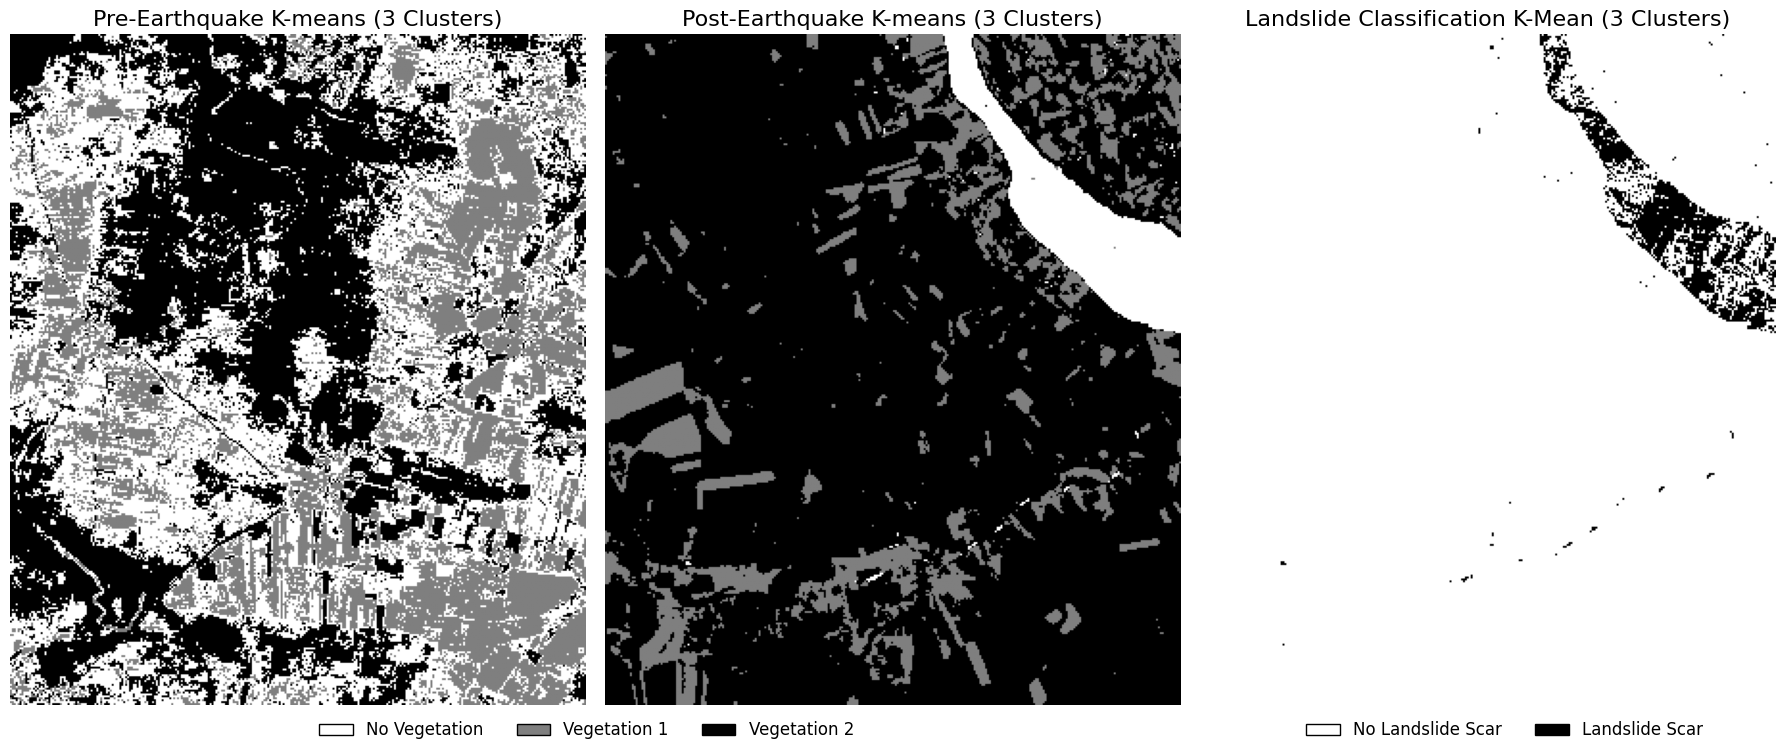

In [22]:
# Create Legend for Binary Cluster Labels
patches = [
    Rectangle((0, 0), 1, 1, facecolor=plt.cm.binary(0), edgecolor='black'),
    Rectangle((0, 0), 1, 1, facecolor=plt.cm.binary(0.5), edgecolor='black'),
    Rectangle((0, 0), 1, 1, facecolor=plt.cm.binary(0.99), edgecolor='black'),
]
labels = ['No Vegetation', 'Vegetation 1', 'Vegetation 2']

scar_patches = [
    Rectangle((0, 0), 1, 1, facecolor=plt.cm.binary(0), edgecolor='black'),
    Rectangle((0, 0), 1, 1, facecolor='black', edgecolor='black')
]
scar_labels = ['No Landslide Scar', 'Landslide Scar']

# Plotting Side-by-Side Result with Shared Legend
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

axes[0].imshow(labels_image_pre, cmap='binary')
axes[0].set_title('Pre-Earthquake K-means (3 Clusters)', fontsize = 16)
axes[0].axis('off')

axes[1].imshow(labels_image_post, cmap='binary')
axes[1].set_title('Post-Earthquake K-means (3 Clusters)', fontsize = 16)
axes[1].axis('off')

axes[2].imshow(landslide_mask_kmeans_3_cluster, cmap='binary')
axes[2].set_title('Landslide Classification K-Mean (3 Clusters)', fontsize = 16)
axes[2].axis('off')

# Add Legend Below First Two Plots
fig.legend(
    handles=patches,
    labels=labels,
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(0.33, -0.05),
    prop={'size': 12},
    frameon=False
)

# Add Landslide Scar Legend under the Third Plot
fig.legend(
    handles=scar_patches,
    labels=scar_labels,
    loc='lower center',
    bbox_to_anchor=(0.84, -0.05),
    ncol=2,
    prop={'size': 12},
    frameon=False
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.02)
plt.show()

# Gaussian Mixture Model - 2 Components
The third approach employs the Gaussian Mixture Model (GMM), an unsupervised learning technique, to differentiate between vegetation and bare soil. In contrast to K-Means, GMM performs soft clustering and accommodates more complex cluster distributions, potentially enhancing the separation of mixed land cover types and minimizing misclassification. In this method, GMM was configured with two components to represent soil and vegetation, respectively.

In [23]:
# Apply GMM on Pre-Earthquake Data
gmm_pre = GaussianMixture(n_components=2, random_state=24095819).fit(Pre_EQ_X)
labels_pre_gmm = gmm_pre.predict(Pre_EQ_X)

# Create Label Image for Pre-Earthquake
labels_image_pre_gmm = np.full(band_stack_pre.shape[:2], -1, dtype=int)
labels_image_pre_gmm[valid_pre_mask] = labels_pre_gmm

# Apply GMM on Post-Earthquake Data
gmm_post = GaussianMixture(n_components=2, random_state=24095819).fit(Post_EQ_X)
labels_post_gmm = gmm_post.predict(Post_EQ_X)

# Create Label Image for Post-Earthquake
labels_image_post_gmm = np.full(band_stack_post.shape[:2], -1, dtype=int)
labels_image_post_gmm[valid_post_mask] = labels_post_gmm

# Landslide mask: vegetation lost
landslide_mask_gmm_2_component = ((labels_image_pre_gmm == 1) & (labels_image_post_gmm == 0)).astype(np.uint8)

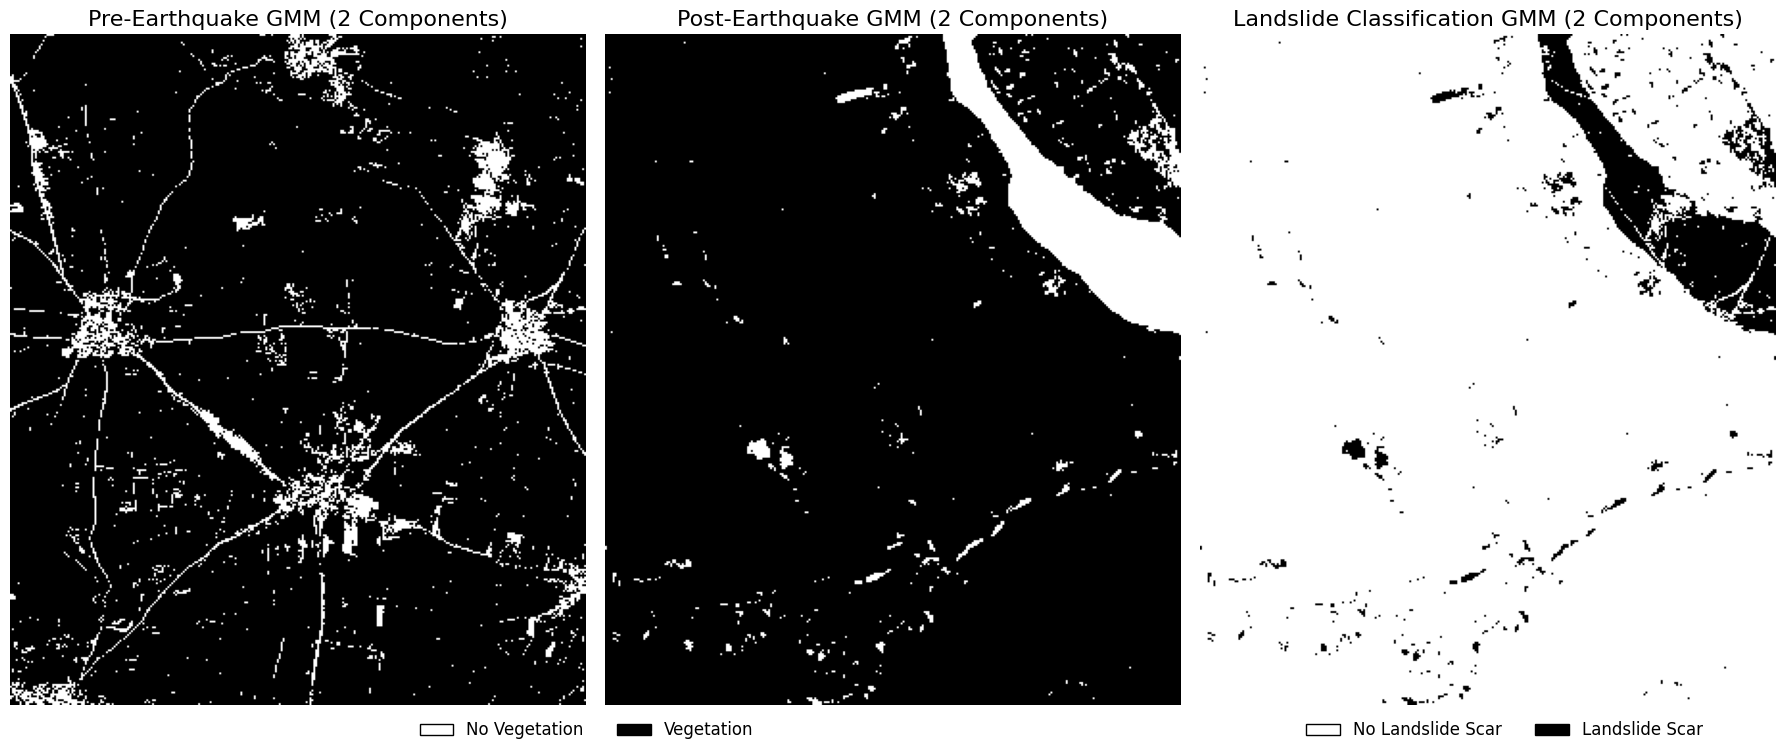

In [24]:
# Create Legend for Binary Cluster Labels
patches = [
    Rectangle((0, 0), 1, 1, facecolor=plt.cm.binary(0), edgecolor='black'),
    Rectangle((0, 0), 1, 1, facecolor=plt.cm.binary(0.99), edgecolor='black'),
]
labels = ['No Vegetation', 'Vegetation']

scar_patches = [
    Rectangle((0, 0), 1, 1, facecolor=plt.cm.binary(0), edgecolor='black'),
    Rectangle((0, 0), 1, 1, facecolor='black', edgecolor='black')
]
scar_labels = ['No Landslide Scar', 'Landslide Scar']

# Plotting Side-by-Side Result with Shared Legend
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

axes[0].imshow(labels_image_pre_gmm, cmap='binary')
axes[0].set_title('Pre-Earthquake GMM (2 Components)', fontsize = 16)
axes[0].axis('off')

axes[1].imshow(labels_image_post_gmm, cmap='binary')
axes[1].set_title('Post-Earthquake GMM (2 Components)', fontsize = 16)
axes[1].axis('off')

axes[2].imshow(landslide_mask_gmm_2_component, cmap='binary')
axes[2].set_title('Landslide Classification GMM (2 Components)', fontsize = 16)
axes[2].axis('off')

# Add Legend Below First Two Plots
fig.legend(
    handles=patches,
    labels=labels,
    loc='lower center',
    ncol=2,
    bbox_to_anchor=(0.33, -0.05),
    prop={'size': 12},
    frameon=False
)

# Add Landslide Scar Legend under the Third Plot
fig.legend(
    handles=scar_patches,
    labels=scar_labels,
    loc='lower center',
    bbox_to_anchor=(0.84, -0.05),
    ncol=2,
    prop={'size': 12},
    frameon=False
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.02)
plt.show()

# Gaussian Mixture Model - 3 Components
As with the K-Means approach, the fourth method utilized GMM with three components instead of two, providing greater flexibility in distinguishing between vegetation and bare soil by accounting for variations and uncertainties in reflectance values.

In [25]:
# Apply GMM on Pre-Earthquake Data
gmm_pre = GaussianMixture(n_components=3, random_state=24095819).fit(Pre_EQ_X)
labels_pre_gmm = gmm_pre.predict(Pre_EQ_X)

# Create Label Image for Pre-Earthquake
labels_image_pre_gmm = np.full(band_stack_pre.shape[:2], -1, dtype=int)
labels_image_pre_gmm[valid_pre_mask] = labels_pre_gmm

# Apply GMM on Post-Earthquake Data
gmm_post = GaussianMixture(n_components=3, random_state=24095819).fit(Post_EQ_X)
labels_post_gmm = gmm_post.predict(Post_EQ_X)

# Create Label Image for Post-Earthquake
labels_image_post_gmm = np.full(band_stack_post.shape[:2], -1, dtype=int)
labels_image_post_gmm[valid_post_mask] = labels_post_gmm

# Reassign Labels in Pre-Earthquake Image
labels_image_pre_gmm[labels_image_pre_gmm == 0] = -10
labels_image_pre_gmm[labels_image_pre_gmm == 2] = 0
labels_image_pre_gmm[labels_image_pre_gmm == -10] = 2

# Reassign Labels in Post-Earthquake Image for Consistency
labels_image_post_gmm = labels_image_post_gmm.copy()
labels_image_post_gmm[labels_image_post_gmm == 0] = -10
labels_image_post_gmm[labels_image_post_gmm == 2] = 0
labels_image_post_gmm[labels_image_post_gmm == -10] = 2

# Landslide mask: vegetation lost
landslide_mask_gmm_3_component = (((labels_image_pre_gmm == 2) | (labels_image_pre_gmm == 1)) & (labels_image_post_gmm == 0)).astype(np.uint8)

[codecarbon INFO @ 16:50:25] Energy consumed for RAM : 0.002083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:50:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:50:25] Energy consumed for All CPU : 0.008853 kWh
[codecarbon INFO @ 16:50:25] 0.010936 kWh of electricity used since the beginning.


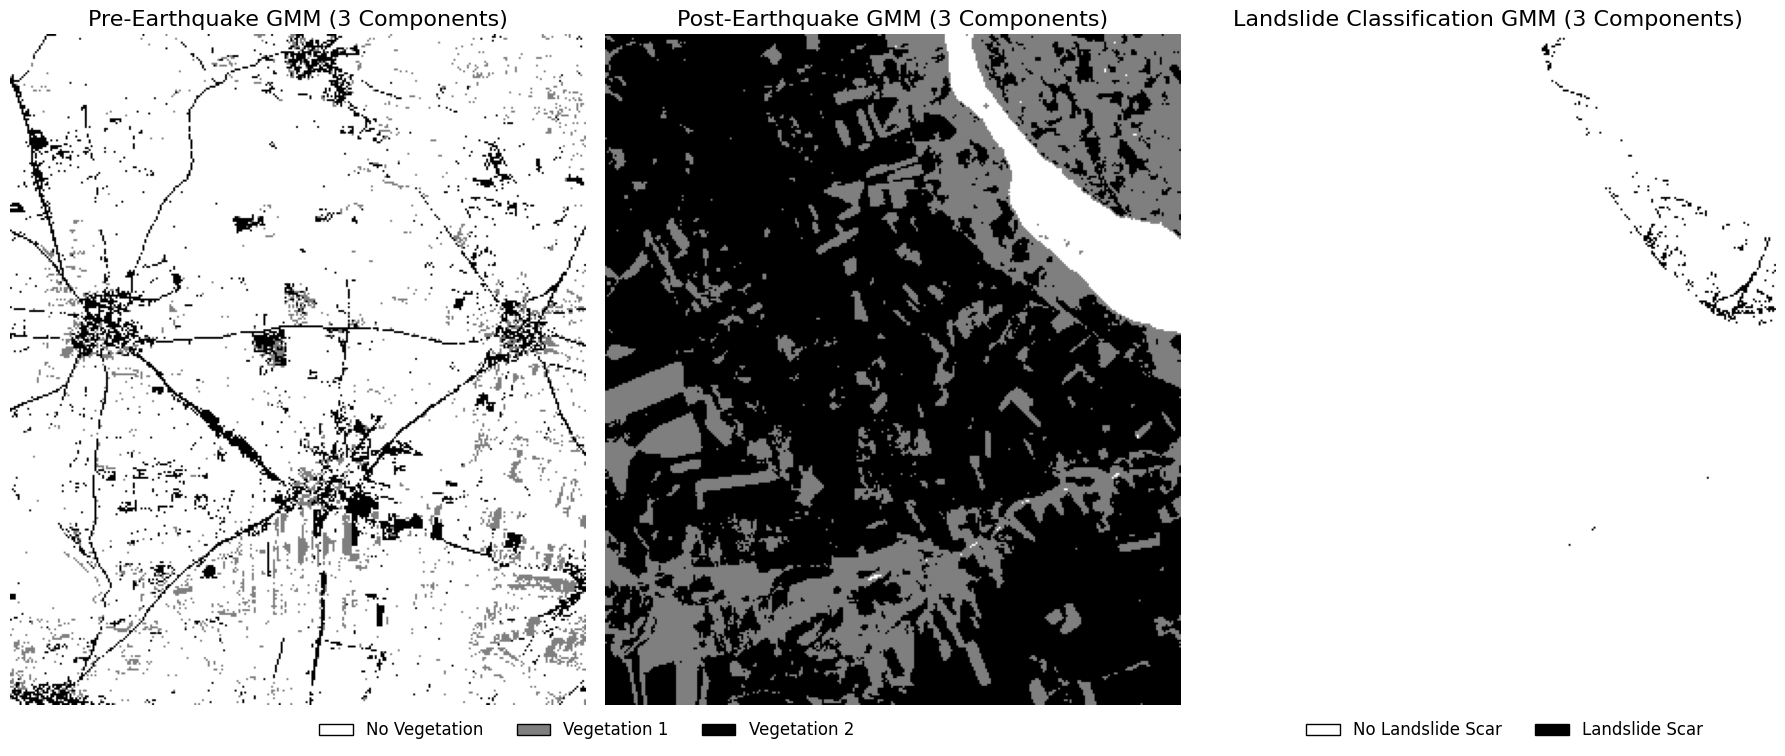

In [26]:
# Create Legend for Binary Cluster Labels
patches = [
    Rectangle((0, 0), 1, 1, facecolor=plt.cm.binary(0), edgecolor='black'),
    Rectangle((0, 0), 1, 1, facecolor=plt.cm.binary(0.5), edgecolor='black'),
    Rectangle((0, 0), 1, 1, facecolor=plt.cm.binary(0.99), edgecolor='black'),
]
labels = ['No Vegetation', 'Vegetation 1', 'Vegetation 2']

scar_patches = [
    Rectangle((0, 0), 1, 1, facecolor=plt.cm.binary(0), edgecolor='black'),
    Rectangle((0, 0), 1, 1, facecolor='black', edgecolor='black')
]
scar_labels = ['No Landslide Scar', 'Landslide Scar']

# Plotting Side-by-Side Result with Shared Legend
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

axes[0].imshow(labels_image_pre_gmm, cmap='binary')
axes[0].set_title('Pre-Earthquake GMM (3 Components)', fontsize = 16)
axes[0].axis('off')

axes[1].imshow(labels_image_post_gmm, cmap='binary')
axes[1].set_title('Post-Earthquake GMM (3 Components)', fontsize = 16)
axes[1].axis('off')

axes[2].imshow(landslide_mask_gmm_3_component, cmap='binary')
axes[2].set_title('Landslide Classification GMM (3 Components)', fontsize = 16)
axes[2].axis('off')

# Add Legend Below First Two Plots
fig.legend(
    handles=patches,
    labels=labels,
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(0.33, -0.05),
    prop={'size': 12},
    frameon=False
)

# Add Landslide Scar Legend under the Third Plot
fig.legend(
    handles=scar_patches,
    labels=scar_labels,
    loc='lower center',
    bbox_to_anchor=(0.84, -0.05),
    ncol=2,
    prop={'size': 12},
    frameon=False
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.02)
plt.show()

# Performance Analysis
To evaluate the performance of the four models, the landslide mask derived from NDVI was used as a reference standard against which the classification results from both K-Means and Gaussian Mixture Model (GMM) approaches were compared. Confusion matrices were generated to measure the level of agreement between the predictions and the reference mask, while overall accuracy scores provided a summary of model performance. Furthermore, precision, recall, and F1 scores were calculated from classification reports to offer a more comprehensive assessment of each method’s ability to detect landslide scars. Lastly, all predicted masks were overlaid onto the post-earthquake true-color imagery to visually compare the effectiveness of the different detection techniques.

In [27]:
# Define Ground Truth and Predicted Masks for Evaluation
landslide_mask_ndvi = landslide_mask

kmeans_2_cluster_result = landslide_mask_kmeans_2_cluster
kmeans_3_cluster_result = landslide_mask_kmeans_3_cluster
gmm_2_component_result = landslide_mask_gmm_2_component
gmm_3_component_result = landslide_mask_gmm_3_component

# Flatten the 2D Masks for Evaluation
ndvi_baseline = landslide_mask_ndvi.flatten()
kmeans_2_cluster_pred = kmeans_2_cluster_result.flatten()
kmeans_3_cluster_pred = kmeans_3_cluster_result.flatten()
gmm_2_component_pred = gmm_2_component_result.flatten()
gmm_3_component_pred = gmm_3_component_result.flatten()

# Compute Confusion Matrices
cm_2_cluster_kmeans = confusion_matrix(ndvi_baseline, kmeans_2_cluster_pred)
cm_3_cluster_kmeans = confusion_matrix(ndvi_baseline, kmeans_3_cluster_pred)
cm_2_component_gmm = confusion_matrix(ndvi_baseline, gmm_2_component_pred)
cm_3_component_gmm = confusion_matrix(ndvi_baseline, gmm_3_component_pred)

# Calculate Overall Accuracy
accuracy_2_cluster_kmeans = accuracy_score(ndvi_baseline, kmeans_2_cluster_pred)
accuracy_3_cluster_kmeans = accuracy_score(ndvi_baseline, kmeans_3_cluster_pred)
accuracy_2_component_gmm = accuracy_score(ndvi_baseline, gmm_2_component_pred)
accuracy_3_component_gmm = accuracy_score(ndvi_baseline, gmm_3_component_pred)

# Generate Detailed Classification Reports (Precision, Recall, F1)
report_2_cluster_kmeans = classification_report(ndvi_baseline, kmeans_2_cluster_pred)
report_3_cluster_kmeans = classification_report(ndvi_baseline, kmeans_3_cluster_pred)
report_2_component_gmm = classification_report(ndvi_baseline, gmm_2_component_pred)
report_3_component_gmm = classification_report(ndvi_baseline, gmm_3_component_pred)

# Print Classification Reports
print("Classification Report for 2-Clusters K-Means:\n", report_2_cluster_kmeans)
print("Classification Report for 3-Clusters K-Means:\n", report_3_cluster_kmeans)
print("Classification Report for 2-Components GMM:\n", report_2_component_gmm)
print("Classification Report for 3-Components GMM:\n", report_3_component_gmm)

# Print Accuracy Scores
print(f"Accuracy for 2-Clusters K-Means: {accuracy_2_cluster_kmeans:.5f}")
print(f"Accuracy for 3-Clusters K-Means: {accuracy_3_cluster_kmeans:.5f}")
print(f"Accuracy for 2-Components GMM: {accuracy_2_component_gmm:.5f}")
print(f"Accuracy for 3-Components GMM: {accuracy_3_component_gmm:.5f}")

Classification Report for 2-Clusters K-Means:
               precision    recall  f1-score   support

           0       1.00      0.58      0.74    104637
           1       0.01      1.00      0.02       363

    accuracy                           0.59    105000
   macro avg       0.50      0.79      0.38    105000
weighted avg       1.00      0.59      0.74    105000

Classification Report for 3-Clusters K-Means:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99    104637
           1       0.08      0.70      0.14       363

    accuracy                           0.97    105000
   macro avg       0.54      0.84      0.56    105000
weighted avg       1.00      0.97      0.98    105000

Classification Report for 2-Components GMM:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97    104637
           1       0.02      0.46      0.05       363

    accuracy                           0.93

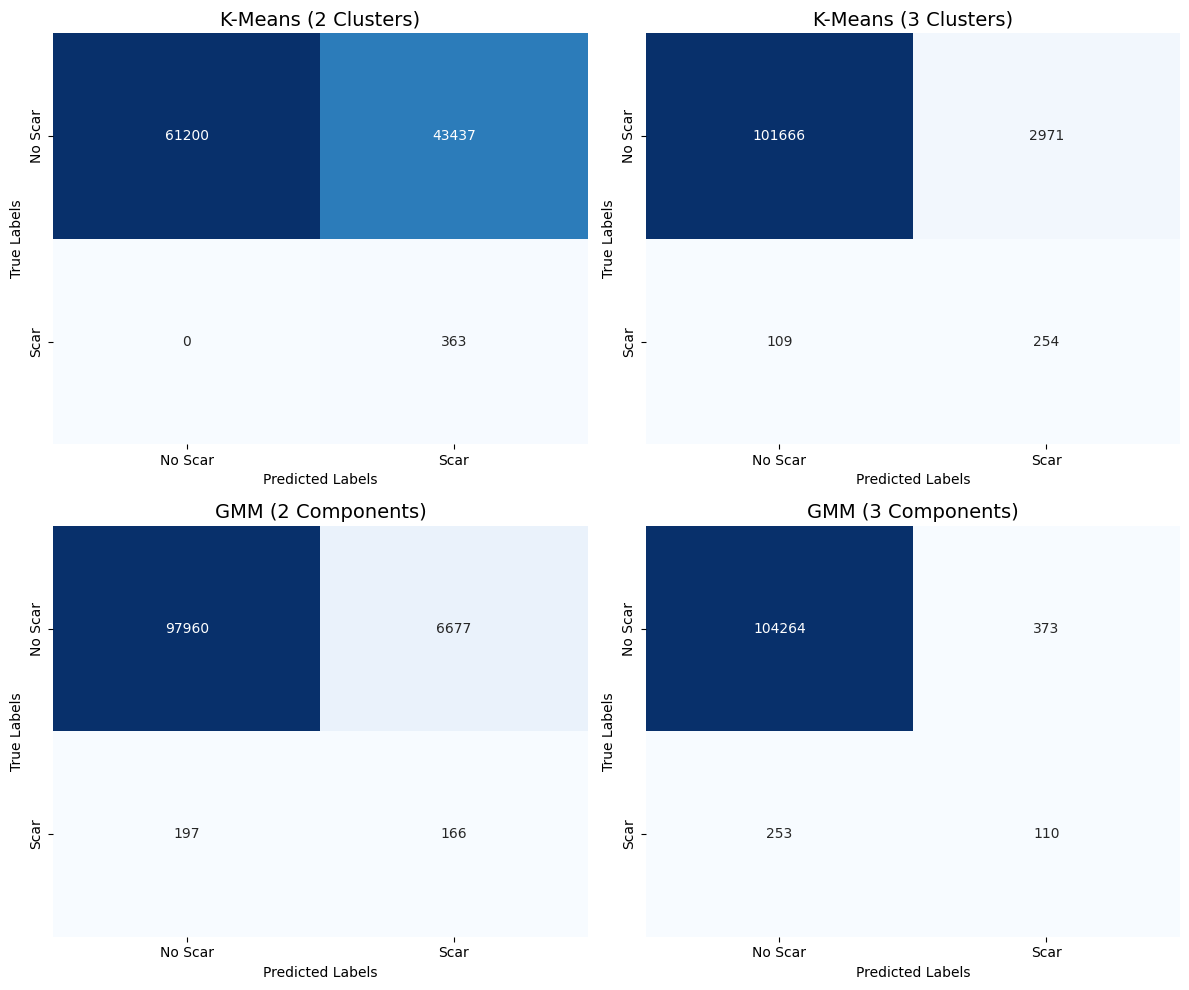

In [28]:
# Labels for axis
labels = ["No Scar", "Scar"]

# Set up the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot each confusion matrix
sns.heatmap(cm_2_cluster_kmeans, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar=False, ax=axes[0, 0])
axes[0, 0].set_title("K-Means (2 Clusters)", fontsize = 14)
axes[0, 0].set_xlabel("Predicted Labels")
axes[0, 0].set_ylabel("True Labels")

sns.heatmap(cm_3_cluster_kmeans, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar=False, ax=axes[0, 1])
axes[0, 1].set_title("K-Means (3 Clusters)", fontsize = 14)
axes[0, 1].set_xlabel("Predicted Labels")
axes[0, 1].set_ylabel("True Labels")

sns.heatmap(cm_2_component_gmm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar=False, ax=axes[1, 0])
axes[1, 0].set_title("GMM (2 Components)", fontsize = 14)
axes[1, 0].set_xlabel("Predicted Labels")
axes[1, 0].set_ylabel("True Labels")

sns.heatmap(cm_3_component_gmm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar=False, ax=axes[1, 1])
axes[1, 1].set_title("GMM (3 Components)", fontsize = 14)
axes[1, 1].set_xlabel("Predicted Labels")
axes[1, 1].set_ylabel("True Labels")

# Adjust layout
plt.tight_layout()
plt.show()

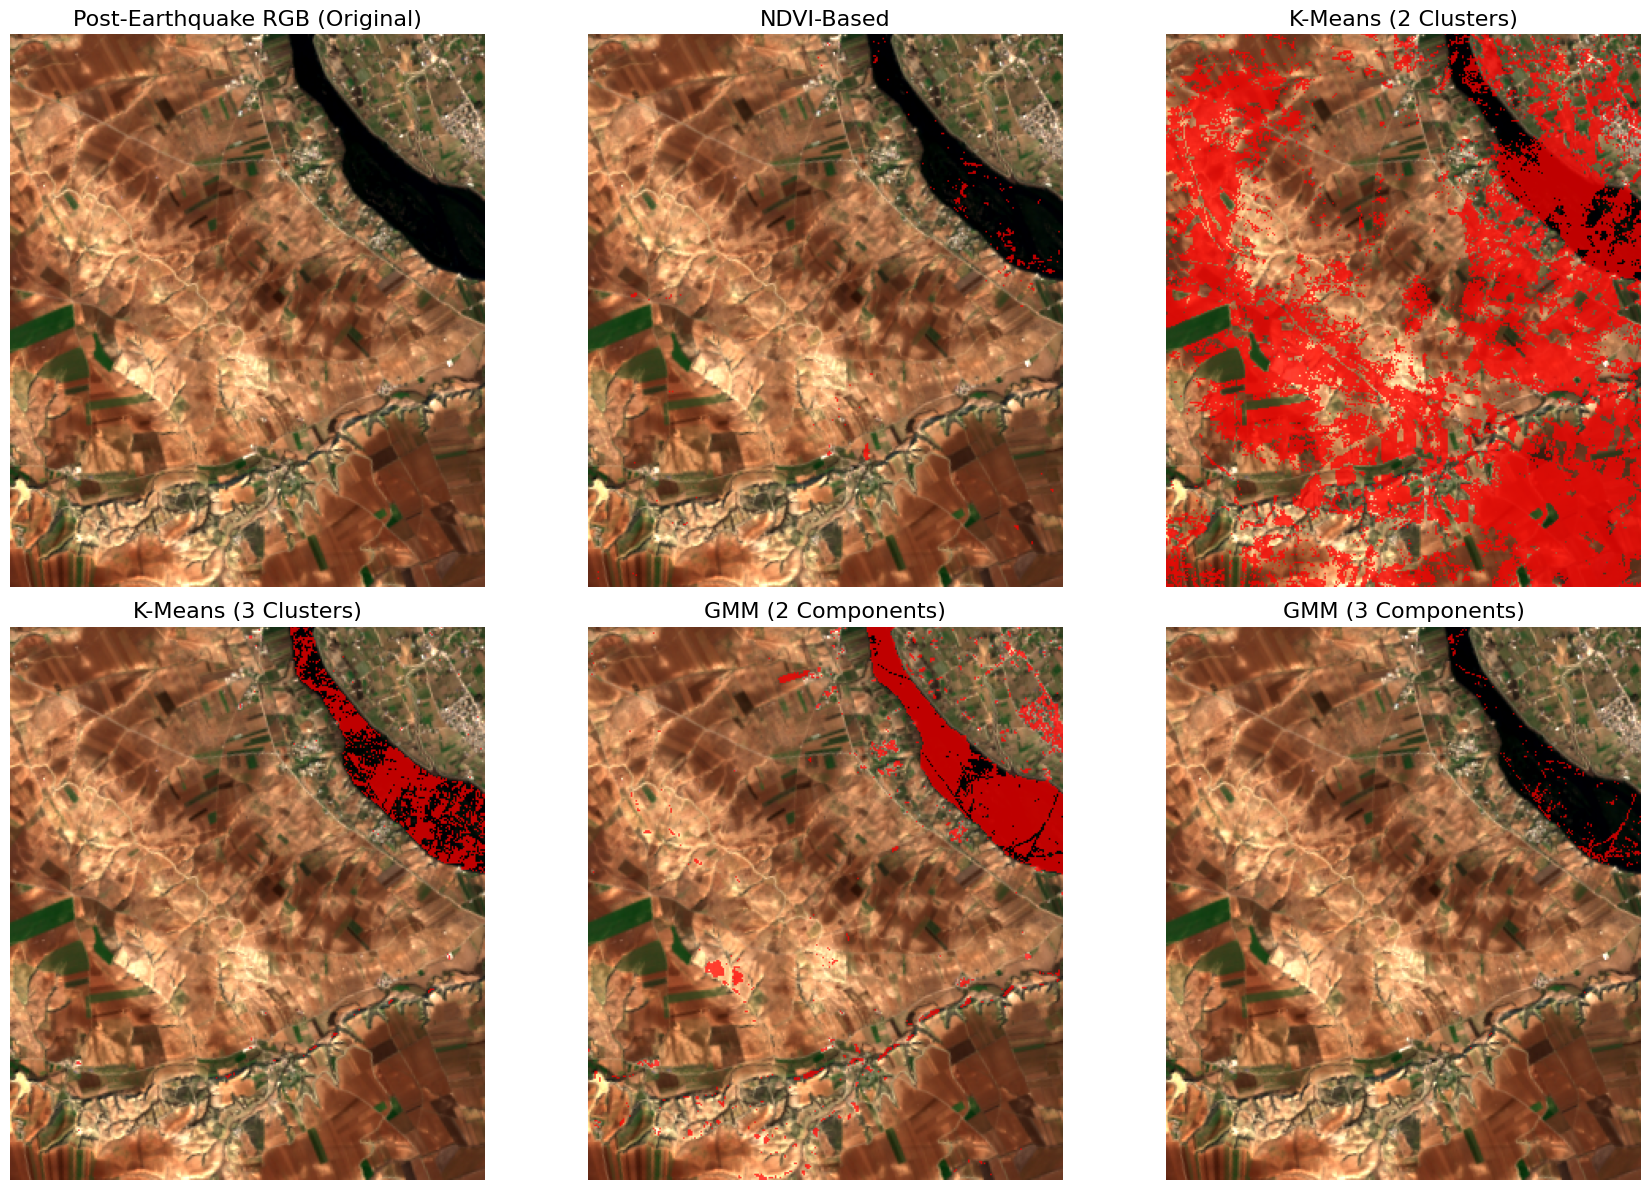

In [29]:
# List of masks and titles
masks = [
    (None, "Post-Earthquake RGB (Original)"),
    (landslide_mask_ndvi, "NDVI-Based"),
    (landslide_mask_kmeans_2_cluster, "K-Means (2 Clusters)"),
    (landslide_mask_kmeans_3_cluster, "K-Means (3 Clusters)"),
    (landslide_mask_gmm_2_component, "GMM (2 Components)"),
    (landslide_mask_gmm_3_component, "GMM (3 Components)")
]

# Create subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Alpha value for blending
alpha = 0.75

# Loop through each image
for i, (mask, title) in enumerate(masks):
    if mask is None:

        image_to_show = rgb_aligned
    else:

        overlay = rgb_aligned.copy()
        red_mask = mask == 1
        red_overlay = np.array([1.0, 0.0, 0.0], dtype=np.float32)  # red


        overlay[red_mask] = (
            (1 - alpha) * overlay[red_mask] + alpha * red_overlay
        )

        image_to_show = overlay

    axes[i].imshow(image_to_show)
    axes[i].set_title(title, fontsize = 16)
    axes[i].axis('off')

plt.tight_layout()
plt.show()